In [2]:
from tensorflow.keras.metrics import CategoricalAccuracy
import tensorflow as tf
from data_loader import get_loader
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
import numpy as np
from models.distances import Euclidean_Distance
from models.stn import BilinearInterpolation,Localization
from sklearn.neighbors import KNeighborsClassifier
from time import time
import os
from models.metrics import accuracy
from tensorflow.keras.metrics import Mean
from sklearn.metrics.pairwise import euclidean_distances as eudist
from sklearn.metrics.pairwise import cosine_distances as codist

In [3]:
def standardize(img):
    mean = np.mean(img)
    std = np.std(img)
    return (img - mean) / std

In [4]:
def normalize(img):
    return (img - np.min(img))/(np.max(img) - np.min(img))

In [6]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_gtsrb2tt100k_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)

In [48]:
loader = get_loader('gtsrb2tt100k') 
_,test_generator = loader.get_generator(batch=128,dim=64)

In [29]:
def run_retrieval(model,generator,number_of_averaging_retrieval=50, dist = eudist):
    t = iter(generator)
    [Xs,Xq],y = next(t)
    n_cls = len(Xs)
    auc = np.empty((n_cls,1))
    retreival_img = np.empty((n_cls,64,64,3))
    number_of_averaging_retrieval = number_of_averaging_retrieval
    for i in range(n_cls):
        print(f'====retreival class {i+1}====')
        z = model(tf.expand_dims(Xs[i],axis=0))
        IM = []
        D = []
        lab = []
        pb = tf.keras.utils.Progbar(len(generator),verbose=1)
        for data in generator:
            [Xs,Xq],y = data
            Zq = model(Xq)
            for k,zq in enumerate(Zq):
                IM += [Xq[k]]
                #zq = loaded_encoder(tf.expand_dims(x,axis=0))
                D += [dist(zq[None,...],z)[0][0]]
                lab += [y[k]]
            pb.add(1)
        D = np.array(D)
        IM = np.array(IM)
        lab = np.array(lab)
        val,indexes =  tf.nn.top_k(-D,k=number_of_averaging_retrieval,sorted=True)
        y_true = np.expand_dims(to_categorical(i,num_classes=n_cls),axis=0)
        auc[i] = tf.keras.metrics.AUC()(lab[indexes],tf.broadcast_to(y_true,lab[indexes].shape))
        img = IM[indexes]
        retreival_img[i] = tf.reduce_mean(img,axis=0)
    return auc,retreival_img
    

In [21]:
auc,retreival_img = run_retrieval(model=loaded_encoder,generator=test_generator,number_of_averaging_retrieval=50)

====retreival class 1====
93/93 [==============================] - 46s 491ms/step
====retreival class 2====
93/93 [==============================] - 47s 504ms/step
====retreival class 3====
93/93 [==============================] - 46s 498ms/step
====retreival class 4====
93/93 [==============================] - 47s 504ms/step
====retreival class 5====
93/93 [==============================] - 47s 503ms/step
====retreival class 6====
93/93 [==============================] - 46s 497ms/step
====retreival class 7====
93/93 [==============================] - 46s 496ms/step
====retreival class 8====
93/93 [==============================] - 47s 503ms/step
====retreival class 9====
93/93 [==============================] - 46s 496ms/step
====retreival class 10====
93/93 [==============================] - 46s 491ms/step
====retreival class 11====
93/93 [==============================] - 46s 490ms/step
====retreival class 12====
93/93 [==============================] - 45s 485ms/step
====retreival

In [23]:
print(f'Average AUC = {tf.reduce_mean(auc):.4f}')

Average AUC = 0.9266


In [24]:
import matplotlib.pyplot as plt

In [25]:
def plot_multi_line(Xs,size=15,font_size=5,hspace=0.1,row_num = 6,col_num=6):
    fig, axes = plt.subplots(nrows=row_num*2,ncols=col_num,
            figsize=(size,size),subplot_kw={'xticks': [], 'yticks': []})
    n = 0
    for row in range(0,2*row_num,2):
        for col in range(col_num):
            axes[row][col].imshow(normalize(Xs[n]))
            #axes[row][col].set_title(names[n],c="green",size=font_size)
            axes[row+1][col].imshow(normalize(retreival_img[n]))
            n += 1
    plt.tight_layout()
    plt.subplots_adjust(hspace=hspace)
    plt.show()

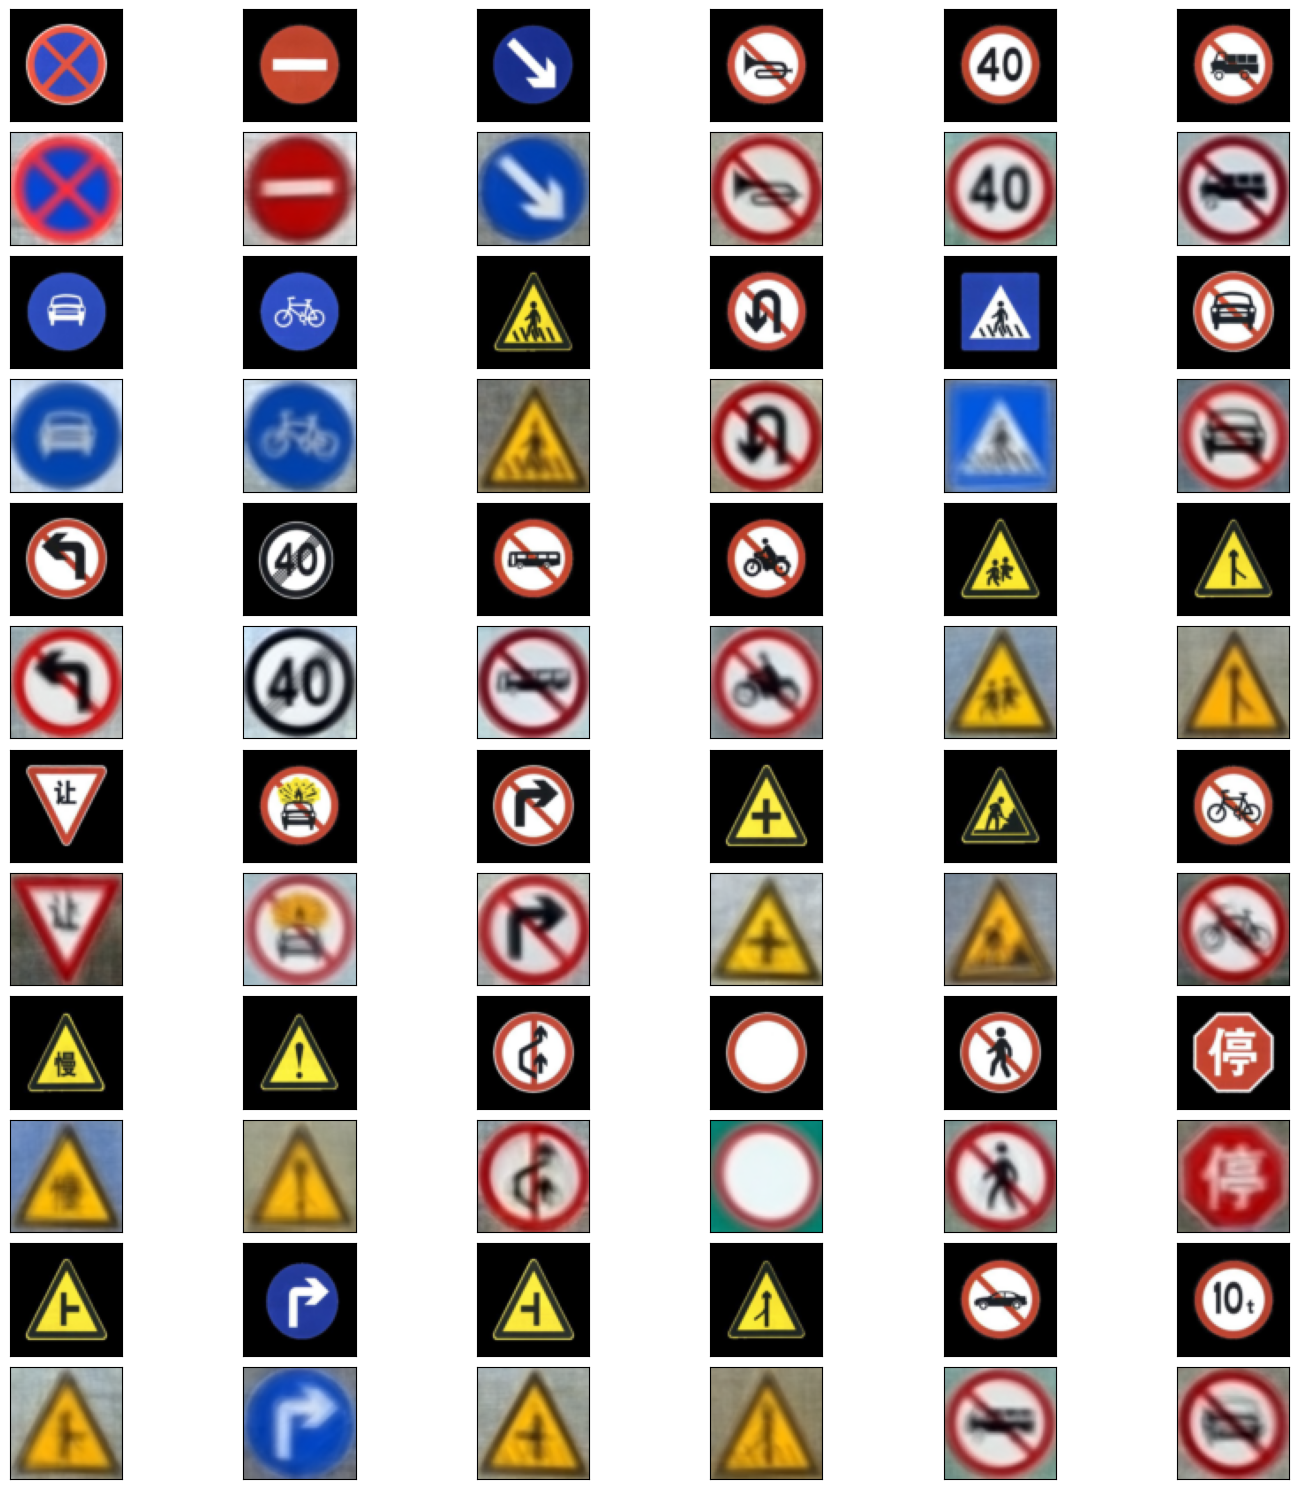

In [26]:
t = iter(test_generator)
[Xs,Xq],y = next(t)
plot_multi_line(Xs)

In [27]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_belga2flick_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)
loader = get_loader('belga2flick') 
test_generator = loader.get_test_generator(batch=128,dim=64)

In [30]:
auc,retreival_img = run_retrieval(model = loaded_encoder, generator = test_generator, number_of_averaging_retrieval=50, dist = codist)

====retreival class 1====
26/26 [==============================] - 17s 631ms/step
====retreival class 2====
26/26 [==============================] - 17s 643ms/step
====retreival class 3====
26/26 [==============================] - 17s 638ms/step
====retreival class 4====
26/26 [==============================] - 17s 663ms/step
====retreival class 5====
26/26 [==============================] - 17s 666ms/step
====retreival class 6====
26/26 [==============================] - 17s 636ms/step
====retreival class 7====
26/26 [==============================] - 16s 628ms/step
====retreival class 8====
26/26 [==============================] - 16s 633ms/step
====retreival class 9====
26/26 [==============================] - 17s 642ms/step
====retreival class 10====
26/26 [==============================] - 18s 676ms/step
====retreival class 11====
26/26 [==============================] - 17s 656ms/step
====retreival class 12====
26/26 [==============================] - 17s 641ms/step
====retreival

In [31]:
print(f'Average AUC = {tf.reduce_mean(auc):.4f}')

Average AUC = 0.9571


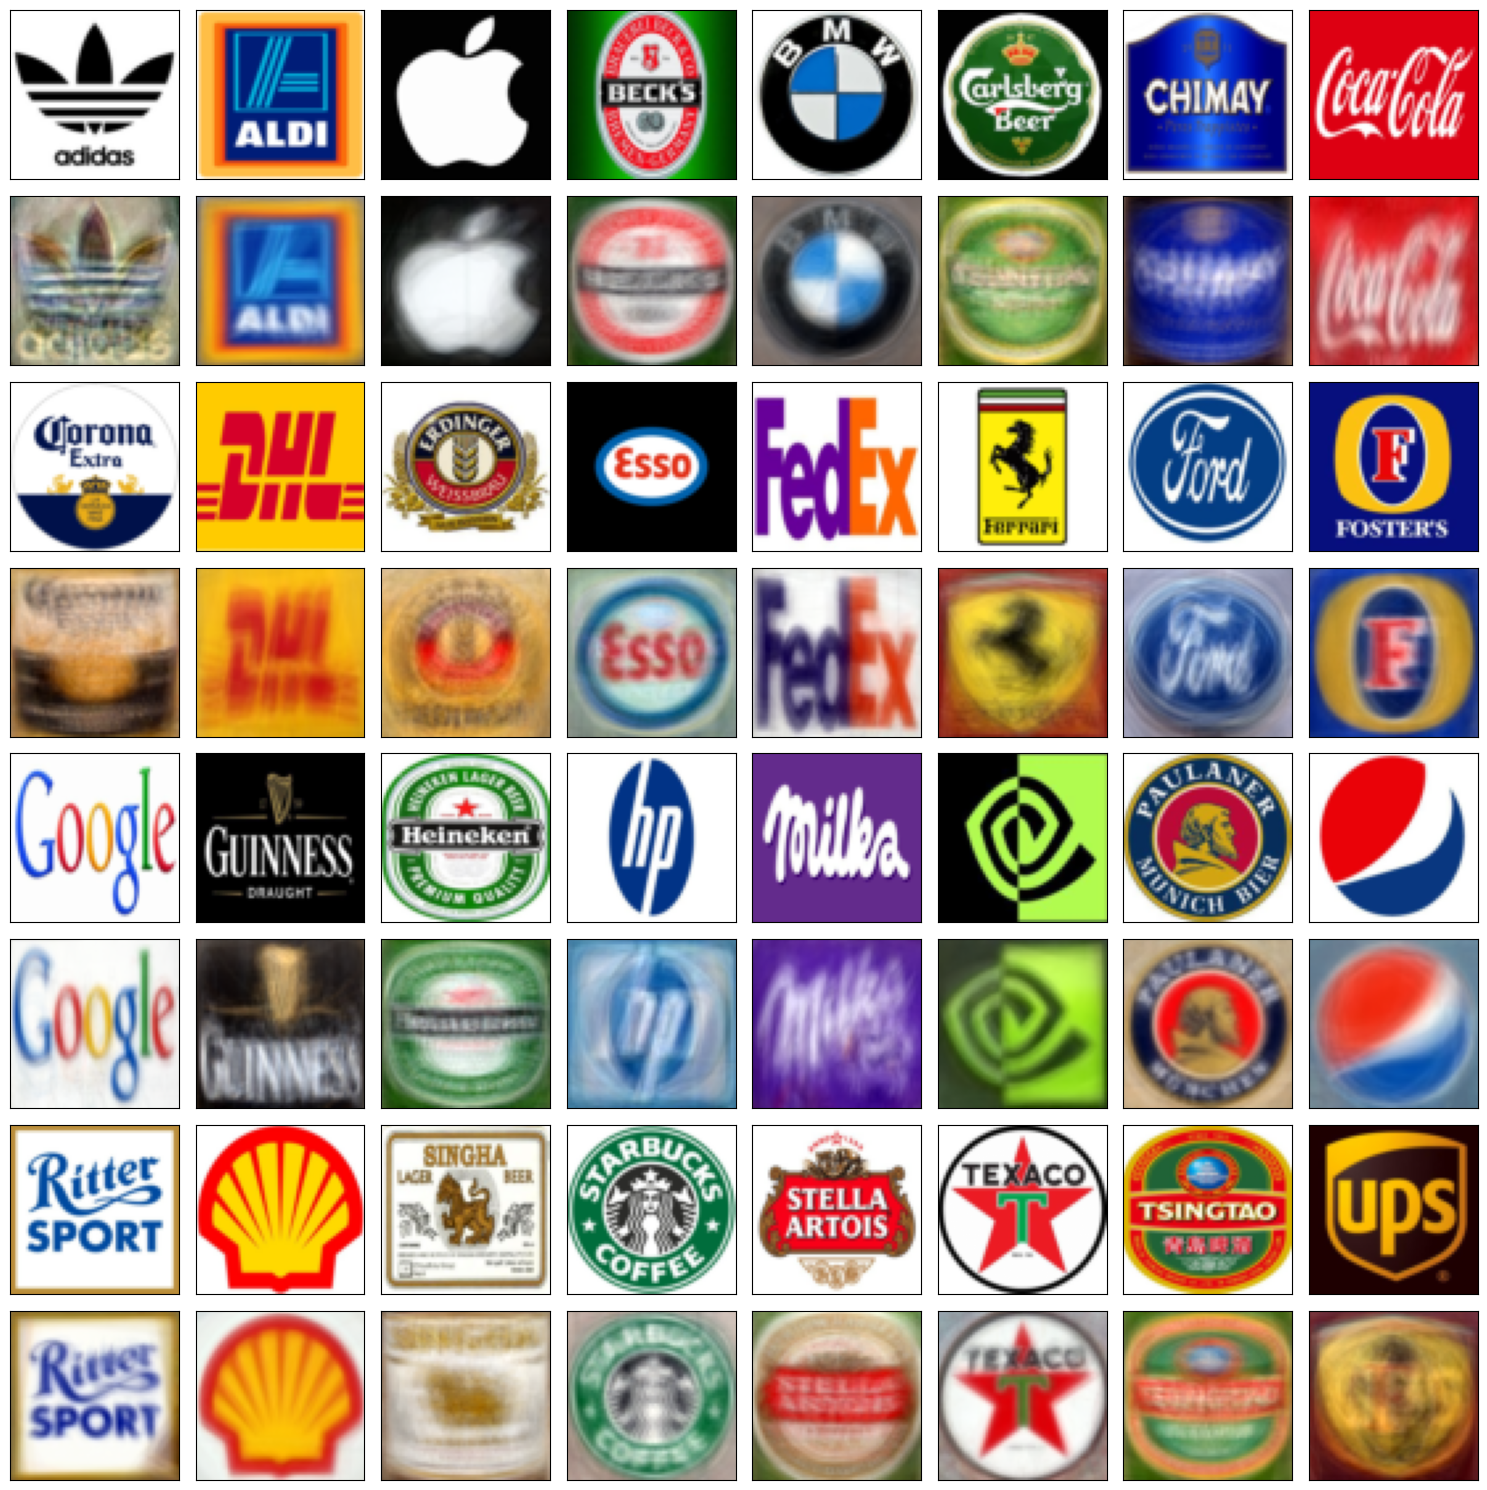

In [32]:
t = iter(test_generator)
[Xs,Xq],y = next(t)
plot_multi_line(Xs,row_num=4,col_num=8)

In [33]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_belga2toplogo_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)
loader = get_loader('belga2toplogo') 
test_generator = loader.get_test_generator(batch=128,dim=64)

In [35]:
auc,retreival_img = run_retrieval(model = loaded_encoder, generator = test_generator, number_of_averaging_retrieval=50, dist = codist)
print(f'Average AUC = {tf.reduce_mean(auc):.4f}')

====retreival class 1====
6/6 [==============================] - 3s 429ms/step
====retreival class 2====
6/6 [==============================] - 3s 493ms/step
====retreival class 3====
6/6 [==============================] - 3s 457ms/step
====retreival class 4====
6/6 [==============================] - 3s 468ms/step
====retreival class 5====
6/6 [==============================] - 3s 430ms/step
====retreival class 6====
6/6 [==============================] - 3s 453ms/step
====retreival class 7====
6/6 [==============================] - 3s 497ms/step
====retreival class 8====
6/6 [==============================] - 3s 458ms/step
====retreival class 9====
6/6 [==============================] - 3s 425ms/step
====retreival class 10====
6/6 [==============================] - 3s 469ms/step
====retreival class 11====
6/6 [==============================] - 3s 440ms/step
Average AUC = 0.8760


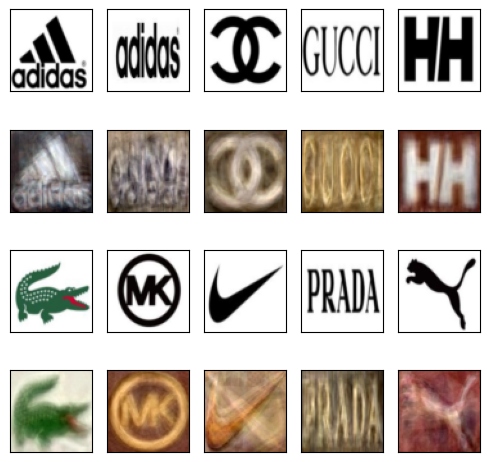

In [36]:
t = iter(test_generator)
[Xs,Xq],y = next(t)
plot_multi_line(Xs,row_num=2,col_num=5,size=5)

In [38]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_gtsrb_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)
loader = get_loader('gtsrb') 
test_generator = loader.get_test_generator(batch=128,dim=64)

In [39]:
auc,retreival_img = run_retrieval(model = loaded_encoder, generator = test_generator, number_of_averaging_retrieval=50, dist = codist)

====retreival class 1====
306/306 [==============================] - 150s 490ms/step
====retreival class 2====
306/306 [==============================] - 152s 498ms/step
====retreival class 3====
306/306 [==============================] - 147s 480ms/step
====retreival class 4====
306/306 [==============================] - 149s 485ms/step
====retreival class 5====
306/306 [==============================] - 155s 506ms/step
====retreival class 6====
306/306 [==============================] - 145s 474ms/step
====retreival class 7====
306/306 [==============================] - 149s 487ms/step
====retreival class 8====
306/306 [==============================] - 142s 464ms/step
====retreival class 9====
306/306 [==============================] - 144s 469ms/step
====retreival class 10====
306/306 [==============================] - 141s 460ms/step
====retreival class 11====
306/306 [==============================] - 141s 461ms/step
====retreival class 12====
306/306 [===========================

In [40]:
print(f'Average AUC = {tf.reduce_mean(auc):.4f}')

Average AUC = 0.9983


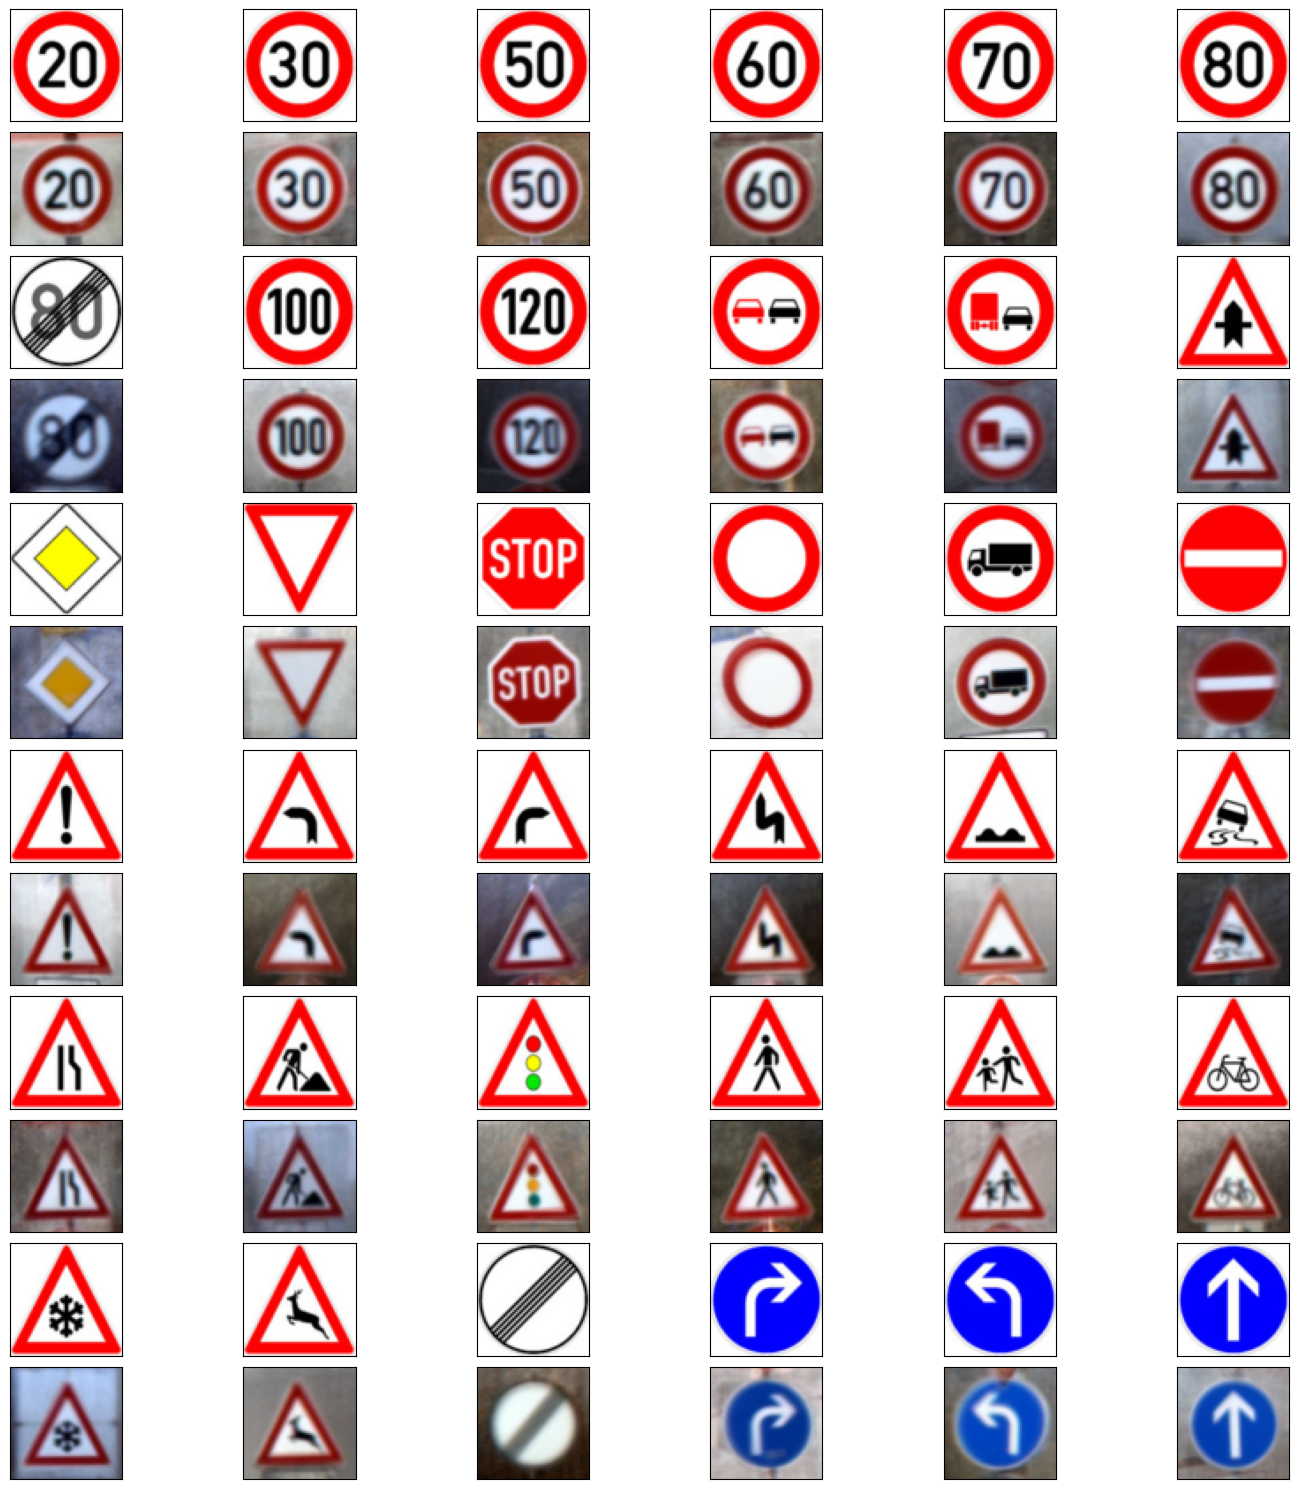

In [44]:
t = iter(test_generator)
[Xs,Xq],y = next(t)
plot_multi_line(Xs)

In [7]:
from sklearn.manifold import TSNE

In [8]:
tsne = TSNE()

In [9]:
loader = get_loader('gtsrb2tt100k') 
test_generator = loader.get_test_generator(batch=10000,dim=64,shuffle=True)

In [10]:
t = iter(test_generator)
[Xs,Xq],y = next(t)


In [11]:
from tensorflow.keras.utils import to_categorical

In [12]:
y = np.argmax(y,axis=-1)

In [13]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_gtsrb2tt100k_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)

In [14]:
z = loaded_encoder(Xq)
x_new = tsne.fit_transform(z)

2023-04-07 17:07:12.494666: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-04-07 17:07:19.494968: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


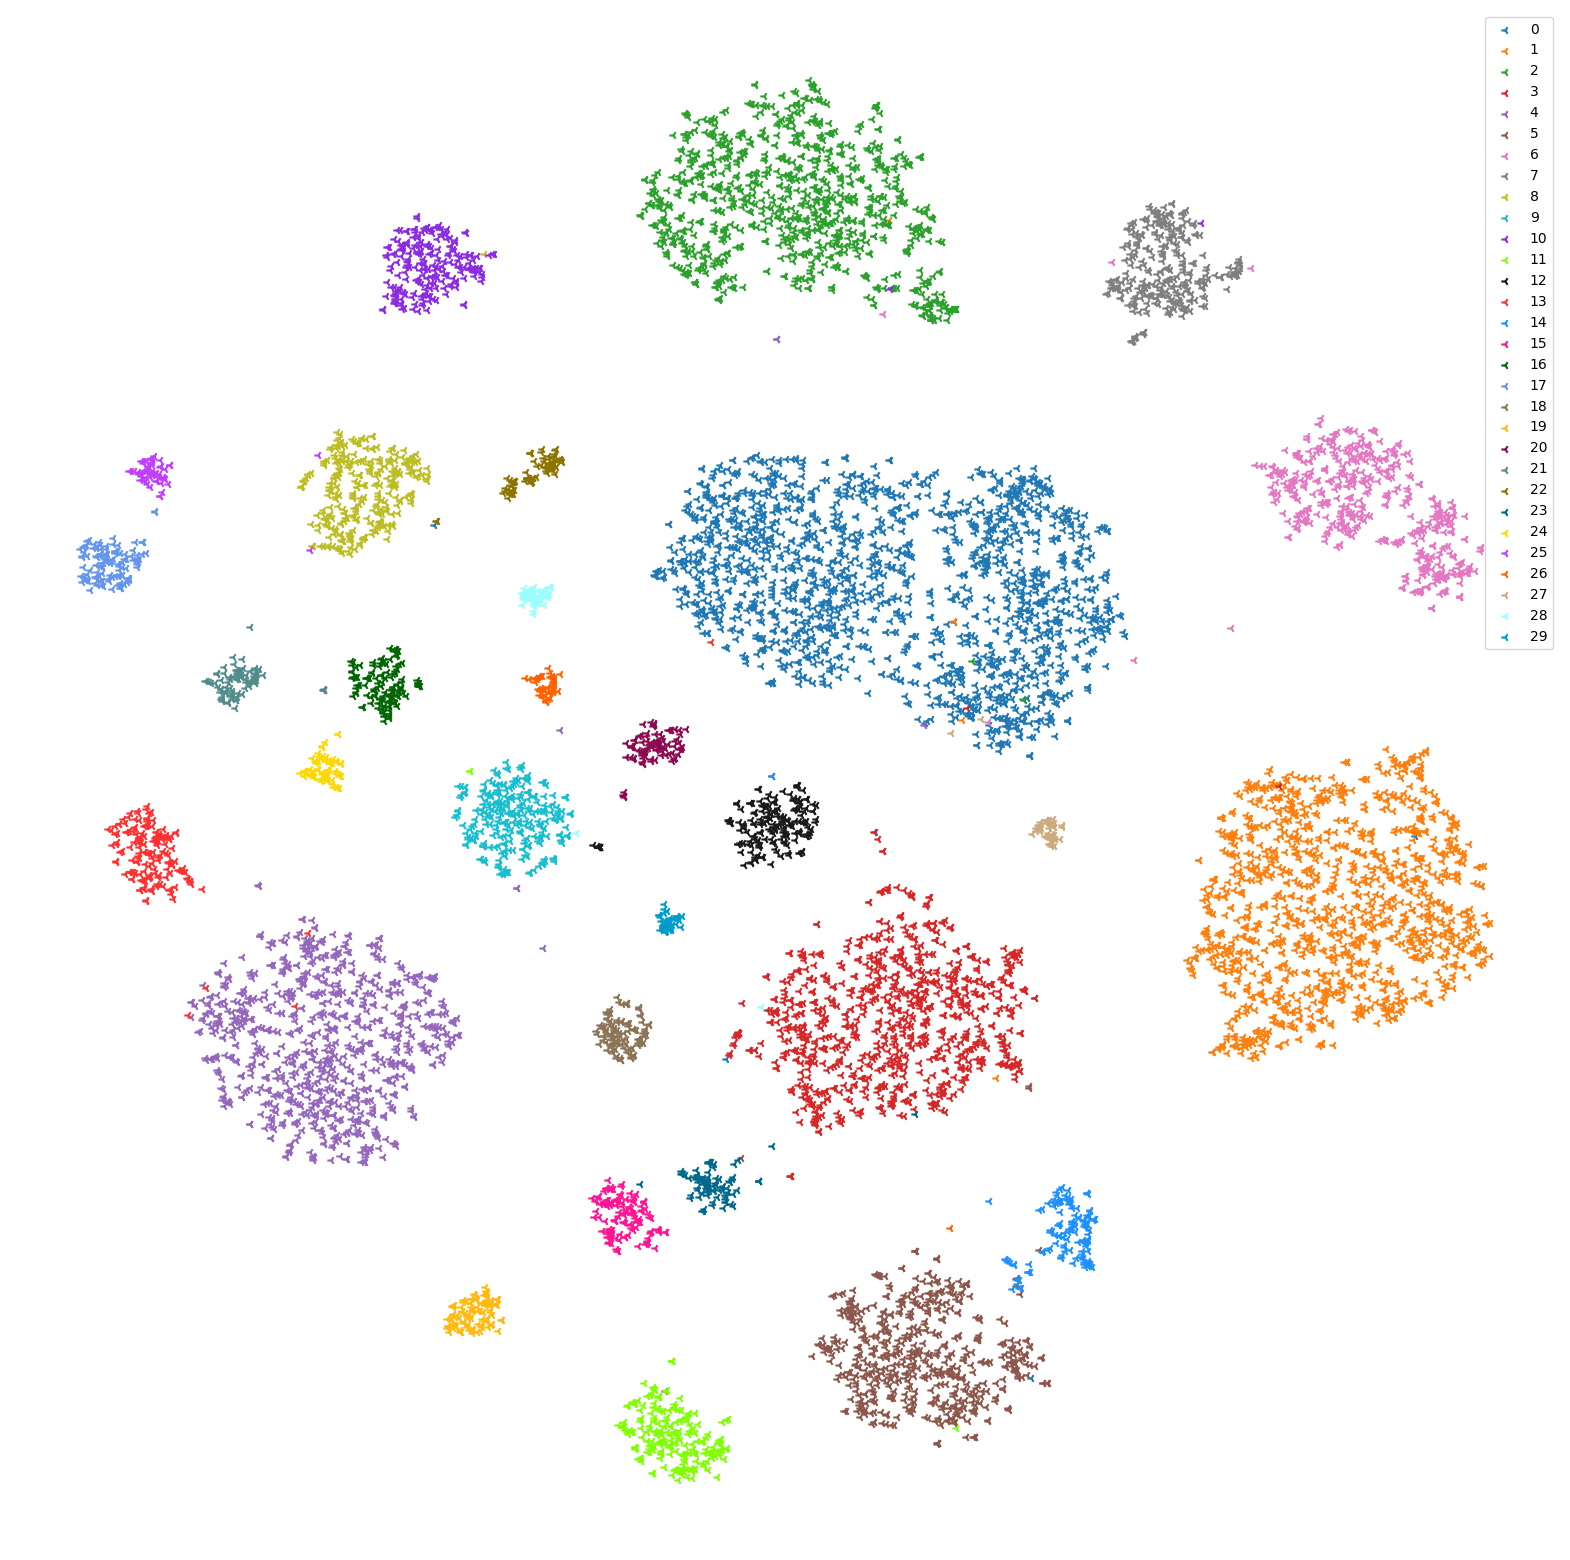

In [47]:
target_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf','#8A2BE2','#7FFF00','#1A1A1A','#FF3030','#1E90FF','#FF1493','#006400',
         '#6495ED','#8B7355','#FFB90F','#8B0A50','#528B8B','#8B7500','#00688B','#FFD700','#BF3EFF','#FF6103','#CDAA7D','#97FFFF','#009ACD']
target_ids = range(len(target_names))
fig = plt.figure(figsize=(20,20))
plt.axis('off')
for i, c, label in zip(target_ids, colors, target_names):
    #plt.scatter(x_new[y == i, 0], x_new[y == i, 1], c=c, marker='3')
    plt.scatter(x_new[y == i, 0], x_new[y == i, 1], c=c, label=label, marker='3')
plt.legend()
plt.show()


In [54]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenet_gtsrb2tt100k_encoder_random.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)

In [55]:
z = loaded_encoder(Xq)
x_new = tsne.fit_transform(z)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


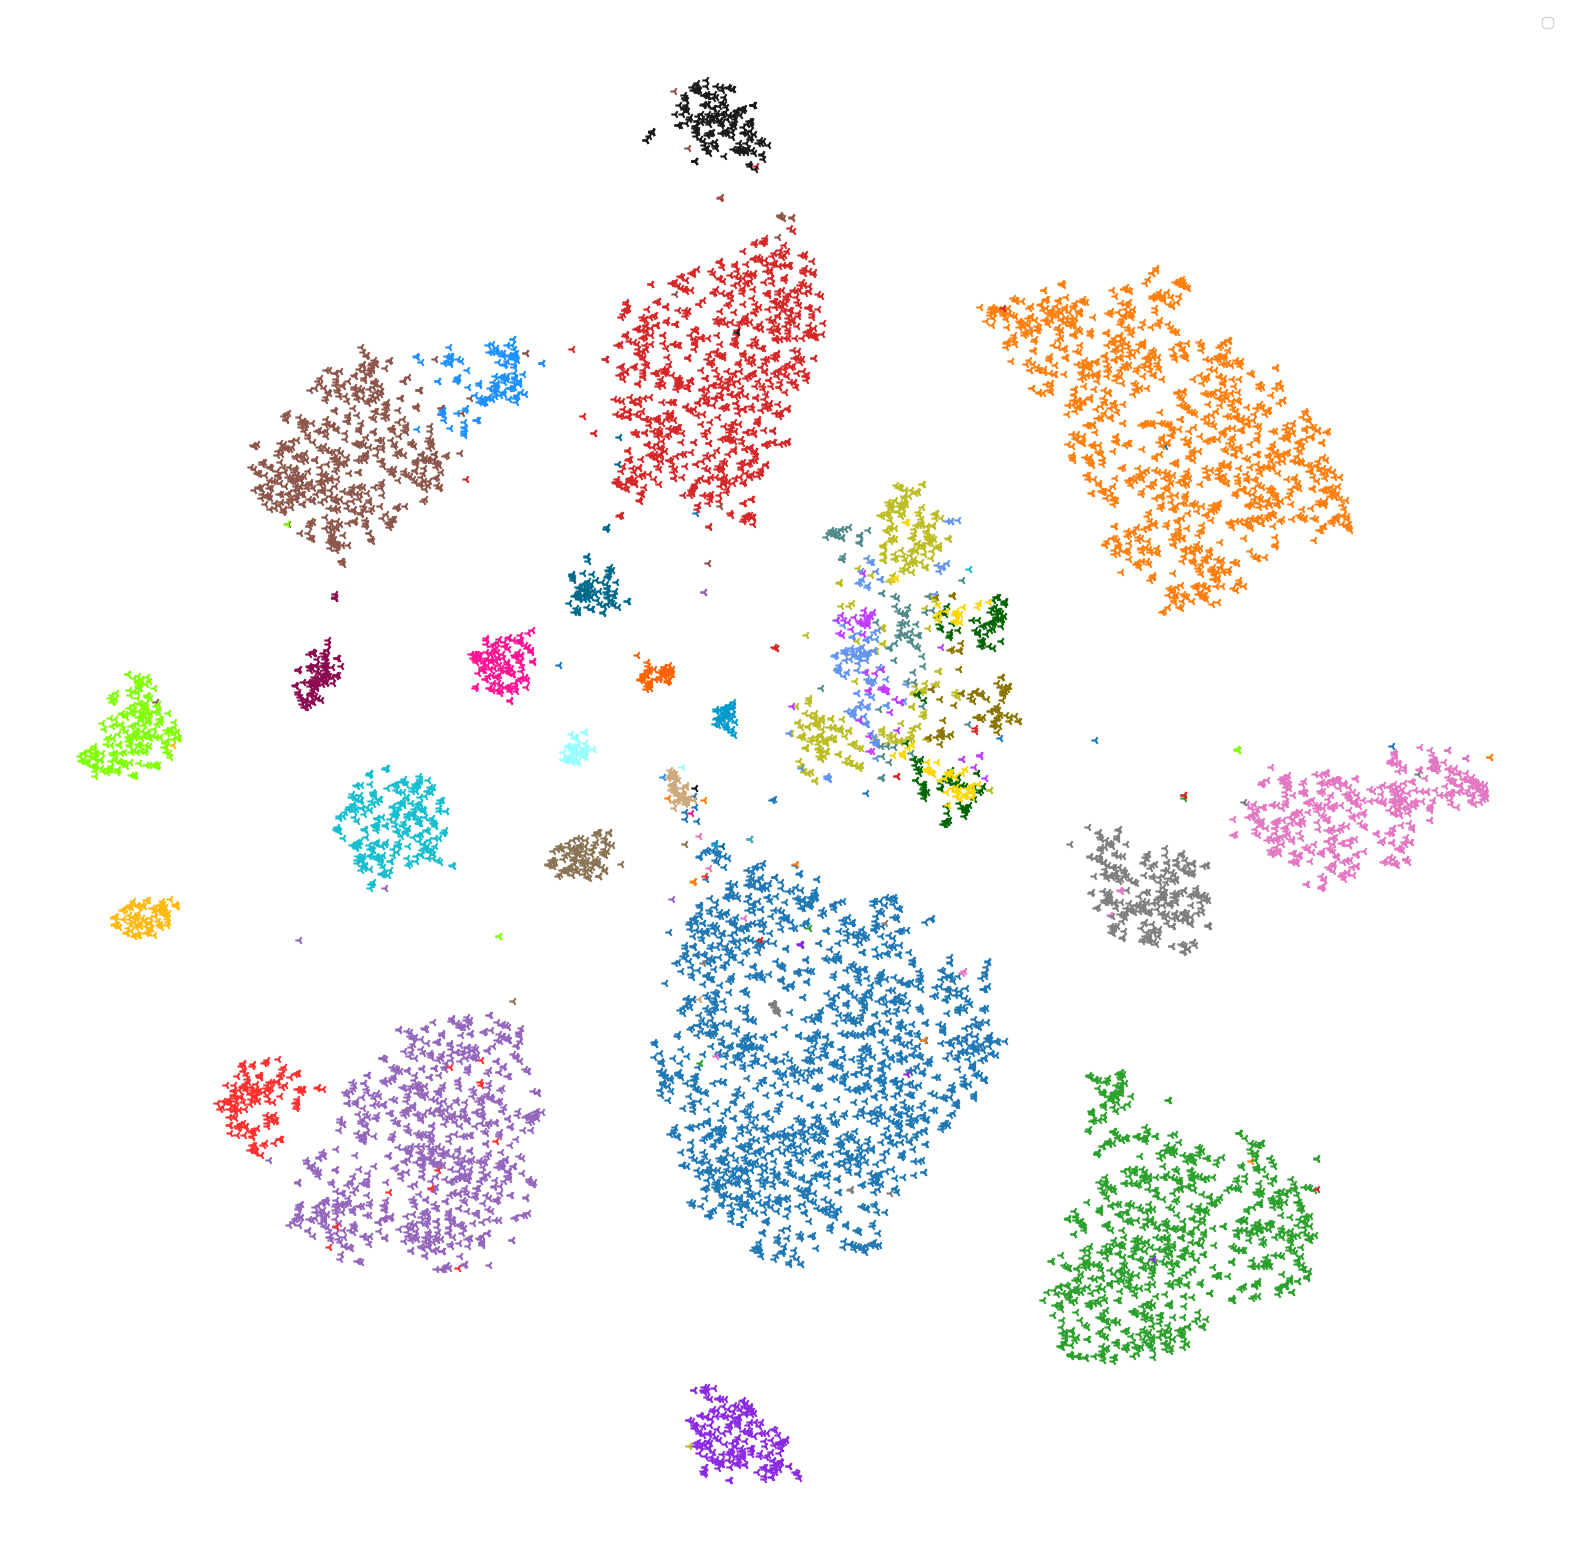

In [56]:
target_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf','#8A2BE2','#7FFF00','#1A1A1A','#FF3030','#1E90FF','#FF1493','#006400',
         '#6495ED','#8B7355','#FFB90F','#8B0A50','#528B8B','#8B7500','#00688B','#FFD700','#BF3EFF','#FF6103','#CDAA7D','#97FFFF','#009ACD']
target_ids = range(len(target_names))
fig = plt.figure(figsize=(20,20))
plt.axis('off')
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(x_new[y == i, 0], x_new[y == i, 1], c=c, marker='3')
    #plt.scatter(x_new[y == i, 0], x_new[y == i, 1], c=c, label=label, marker='3')
plt.legend()
plt.show()


In [48]:
loaded_encoder = keras.models.load_model(
    'model_files/best_encoders/densenetmini_gtsrb2tt100k_encoder.h5',
    custom_objects={'BilinearInterpolation':BilinearInterpolation,'Localization':Localization},compile=True)

In [49]:
z = loaded_encoder(Xq)
x_new = tsne.fit_transform(z)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


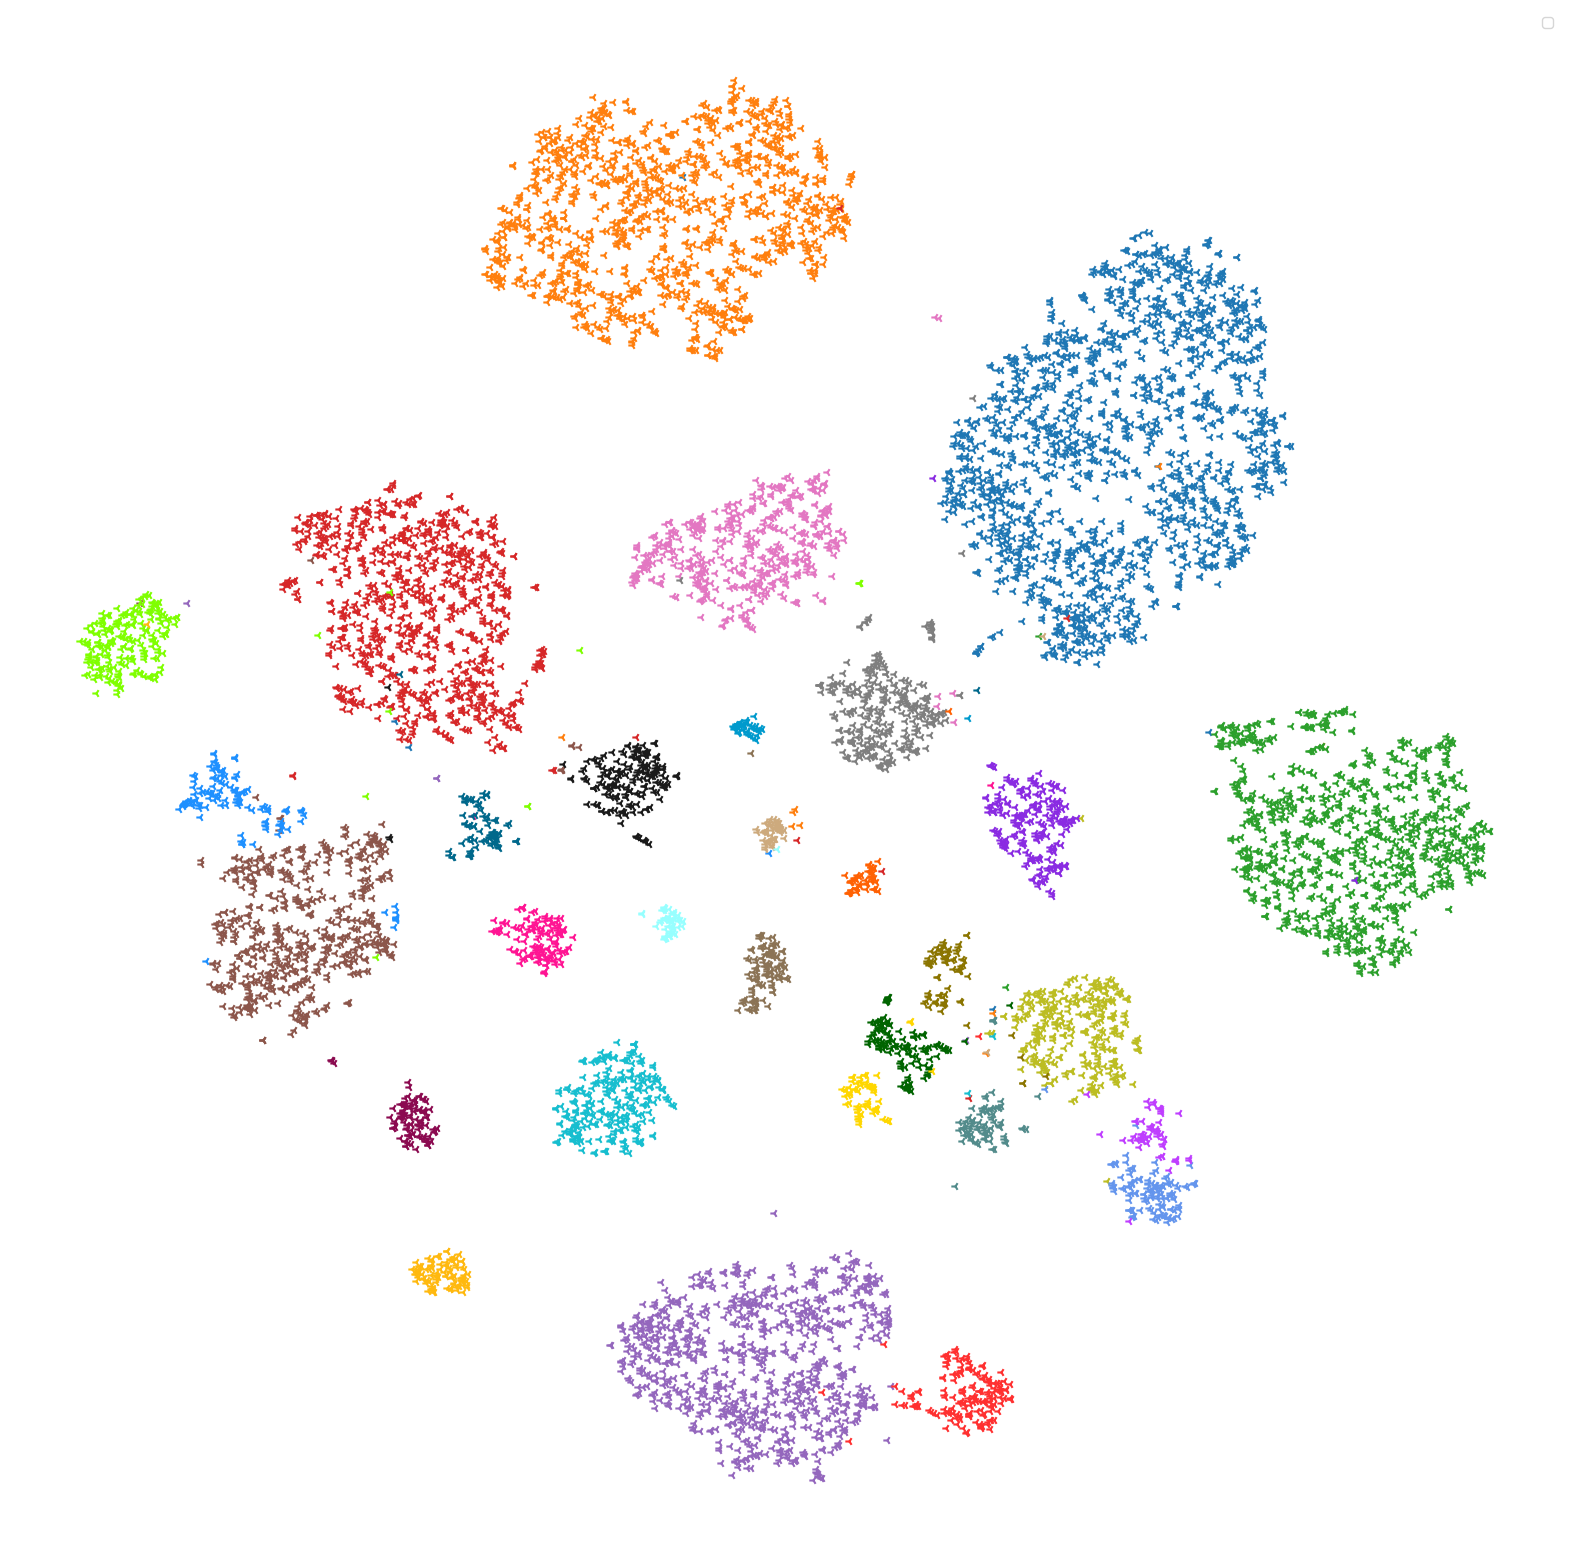

In [50]:
target_names = ['0','1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','29']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf','#8A2BE2','#7FFF00','#1A1A1A','#FF3030','#1E90FF','#FF1493','#006400',
         '#6495ED','#8B7355','#FFB90F','#8B0A50','#528B8B','#8B7500','#00688B','#FFD700','#BF3EFF','#FF6103','#CDAA7D','#97FFFF','#009ACD']
target_ids = range(len(target_names))
fig = plt.figure(figsize=(20,20))
plt.axis('off')
for i, c, label in zip(target_ids, colors, target_names):
    plt.scatter(x_new[y == i, 0], x_new[y == i, 1], c=c, marker='3')
    #plt.scatter(x_new[y == i, 0], x_new[y == i, 1], c=c, label=label, marker='3')
plt.legend()
plt.show()
